In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### Importing Data

In [3]:
PATH = "data/IRA Data/IRADATA.xlsx"
xls = pd.ExcelFile(PATH)

In [4]:
codebook = pd.read_excel(xls, 'Codebook')
p2_attr = pd.read_excel(xls, 'Period2_Attribute')
p2_netw = pd.read_excel(xls, 'Period2_Network')

# Removing missing values
p2_data = p2_attr[['ID', 'Antrim Brigade', 'Armagh Brigade', 'Down Brigade', 
                   'Derry Brigade', 'Tyrone Brigade', 'Fermanagh Brigade']]
p2_data = p2_data[~p2_data.isin([99999]).any(axis=1)].reset_index(drop=True)

# Changing Dataframe to make graph construction easier
p2_data.rename(columns={"ID" : "Node Label"}, inplace=True)
p2_data.head(3)

,Node Label,Antrim Brigade,Armagh Brigade,Down Brigade,Derry Brigade,Tyrone Brigade,Fermanagh Brigade
0,ZF1001,0,0,0,1,0,0
1,ZF1007,0,0,0,1,0,0
2,ZF1025,0,0,0,1,0,0


## Analyzing LCC based on attributes
Attributes: 'Gender', 'University', 'Marital Status', 'Age at Recruitment', 'Antrim Brigade', 'Derry Brigade', 'Armagh Brigade', 'Down Brigade', 'Tyrone Brigade', 'Fermanagh Brigade'

In [5]:
p2_adj = p2_netw.set_index('Unnamed: 0')
G_from_netw = nx.from_pandas_adjacency(p2_adj)

In [27]:
def get_cat_df(data, category, categorical_df=True, median_age=28, drop_invalid_rows=False):
    if drop_invalid_rows:
        cat_df = data[~data[category].isin([99999])][['ID', category]]
    else:
        cat_df = data[['ID', category]]
    if 'age' in category.lower():
        cat_df['Age at Recruitment'] = cat_df['Age at Recruitment'].apply(lambda x: 0 if x < median_age else 1)
    if categorical_df:
        cat_df[category] = pd.Categorical(cat_df[category])    
    return cat_df.set_index('ID')

In [28]:
# Get node attribute data
node_attr = p2_attr.copy().replace(99999, 'N/A').iloc[:, :11] 
node_attr['Age at Recruitment'] = node_attr['Age at Recruitment'].apply(lambda x: int(x) if x != 'N/A' else np.nan)
node_attr.head(2)

,ID,Gender,University,Marital Status,Age at Recruitment,Antrim Brigade,Derry Brigade,Armagh Brigade,Down Brigade,Tyrone Brigade,Fermanagh Brigade
0,ZF1001,0,0,0,47.0,0,1,0,0,0,0
1,ZF1007,0,0,1,22.0,0,1,0,0,0,0


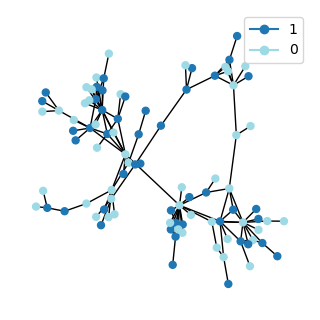

In [29]:
# DOESN'T WORK FOR INDIVIDUAL BRIGADE MEMBERSHIP
CATEGORY = 'Age at Recruitment' 

# Get attributes and largest connected component
df = get_cat_df(node_attr, CATEGORY, categorical_df=True)
cat_subset_graph = G_from_netw.subgraph(df.index)
largest_cc = cat_subset_graph.subgraph(max(nx.connected_components(G_from_netw), key=len))
df = df[df.index.isin(largest_cc.nodes)]

#get the values of the category
cat_values = df[CATEGORY].unique()
colors = [plt.cm.tab20(i/float(len(cat_values)-1)) for i in range(len(cat_values))]

#create a dictionary mapping category values to colors & map nodes to colors
value_to_color = dict(zip(cat_values, colors))
node_colors = [value_to_color[df.loc[n][CATEGORY]] for n in df.index]

#draw the graph
plt.figure(figsize=(3, 3))
nx.draw(largest_cc, node_size=25, node_color=node_colors)

#create a patch for each category value
patches = [plt.plot([],[], marker="o", color=colors[i], 
           label="{}".format(cat_values[i]))[0] for i in range(len(cat_values))]

plt.legend();

#### Distribution of brigade memberships

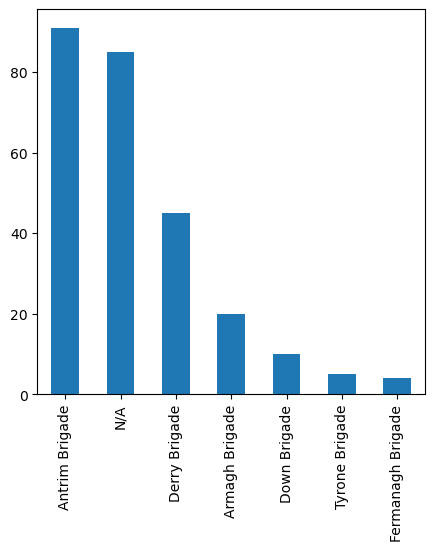

In [30]:
node_attr = p2_attr.copy().replace(99999, 'N/A').iloc[:, [0] + list(range(5, 11))].reset_index(drop=True)
node_attr['Brigade'] = node_attr.apply(lambda row: [col for col in node_attr.columns if row[col] == 1], axis=1)
node_attr['Brigade'] = node_attr['Brigade'].apply(lambda x: ','.join(x) if len(x) >= 1 else 'N/A')

plt.figure(figsize=(5, 5))
node_attr['Brigade'].value_counts().plot(kind='bar');

#### Adjacency Matrix

In [31]:
edge_list = list(nx.edgelist.generate_edgelist(G_from_netw))
edge_list = [edge.split(" ")[:2] for edge in edge_list] 

node_attr = p2_attr.copy().replace(99999, 'N/A').reset_index(drop=True).iloc[:, [0] + list(range(5, 11))]
node_attr['Brigade'] = node_attr.apply(lambda row: [col for col in node_attr.columns if row[col] == 1], axis=1)
node_attr['Brigade'] = node_attr['Brigade'].apply(lambda x: ','.join(x) if len(x) >= 1 else 'N/A')

In [32]:
brigades = node_attr['Brigade'].unique()
adjacency_matrix = np.zeros((len(brigades), len(brigades)))

for edge in edge_list:
    node1_brigade = node_attr[node_attr['ID'] == edge[0]]['Brigade'].iloc[0]
    node2_brigade = node_attr[node_attr['ID'] == edge[1]]['Brigade'].iloc[0]
    
    row_index = np.where(brigades == node1_brigade)[0][0]
    col_index = np.where(brigades == node2_brigade)[0][0]
    
    adjacency_matrix[row_index, col_index] += 1

# Since this is undirected, count the edges twice.
adjacency_matrix += adjacency_matrix.T
adjacency_df = pd.DataFrame(adjacency_matrix, index=brigades, columns=brigades)

adjacency_df.div(adjacency_df.sum(axis=1), axis=0).head(2)

,Derry Brigade,N/A,Armagh Brigade,Antrim Brigade,Down Brigade,Fermanagh Brigade,Tyrone Brigade
Derry Brigade,0.703448,0.137931,0.027586,0.117241,0.013793,0.00000,0.000000
N/A,0.092166,0.543779,0.023041,0.244240,0.032258,0.02765,0.036866


# Distribution of in-group / out-group degrees

Attributes: 'Gender', **'University'**, 'Marital Status', **'Age at Recruitment'**, **'Antrim Brigade'**, **'Derry Brigade'**, 'Armagh Brigade', 'Down Brigade', 'Tyrone Brigade', 'Fermanagh Brigade'

In [57]:
CATEGORY = 'Antrim Brigade'

In [58]:
def get_node_degrees(single_node, lcc, nodes_0, nodes_1):
    neighbors = list(lcc.neighbors(single_node))

    # Count the number of connections within each group
    connections_0 = sum([1 for neighbor in neighbors if neighbor in nodes_0])
    connections_1 = sum([1 for neighbor in neighbors if neighbor in nodes_1])
    return connections_0, connections_1

In [59]:
# Get relevant data
node_attr = p2_attr.copy().iloc[:, :11] 
df = get_cat_df(node_attr, CATEGORY, categorical_df=False, drop_invalid_rows=True)

# Construct graph (go from G_from_netw --> subgraph of these indices --> LCC)
G = G_from_netw.subgraph(df.index)
cat_subset_G = G.subgraph(df.index)
lcc = cat_subset_G.subgraph(max(nx.connected_components(cat_subset_G), key=len))
lcc_df = df[df.index.isin(lcc.nodes)]

# Separate nodes into two groups (for each possible value in the category)
node_to_value = {}
for node in lcc.nodes():
    category_value = lcc_df[lcc_df.index == node][CATEGORY][0]
    node_to_value[node] = category_value

nodes_0 = [key for key, value in node_to_value.items() if value == 0]
nodes_1 = [key for key, value in node_to_value.items() if value == 1]

# Assemble data for the histograms
attr_1_in_group_degrees = []
attr_1_out_group_degrees = []
attr_0_in_group_degrees = []
attr_0_out_group_degrees = []

for node in nodes_1:
    connections_0, connections_1 = get_node_degrees(node, lcc, nodes_0, nodes_1)
    total_degree = connections_0 + connections_1
    attr_1_in_group_degrees.append(connections_1 / total_degree)
    attr_1_out_group_degrees.append(connections_0 / total_degree)

for node in nodes_0:
    connections_0, connections_1 = get_node_degrees(node, lcc, nodes_0, nodes_1)
    total_degree = connections_0 + connections_1
    attr_0_in_group_degrees.append(connections_1 / total_degree)
    attr_0_out_group_degrees.append(connections_0 / total_degree)

Proportion of nodes in group 0: 0.6896551724137931
Proportion of nodes in group 1: 0.3103448275862069
Total number of nodes: 87


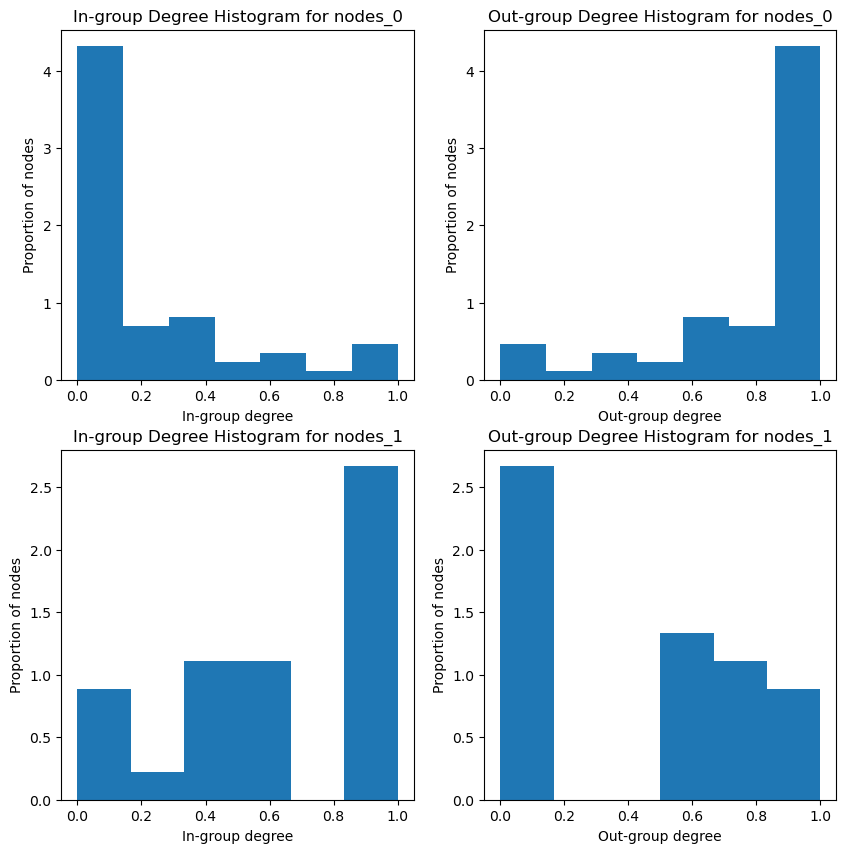

In [60]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# In-group degree histogram for nodes_1
axs[1, 0].hist(attr_1_in_group_degrees, bins='auto', density=True)
axs[1, 0].set_xlabel('In-group degree')
axs[1, 0].set_ylabel('Proportion of nodes')
axs[1, 0].set_title('In-group Degree Histogram for nodes_1')

# Out-group degree histogram for nodes_1
axs[1, 1].hist(attr_1_out_group_degrees, bins='auto', density=True)
axs[1, 1].set_xlabel('Out-group degree')
axs[1, 1].set_ylabel('Proportion of nodes')
axs[1, 1].set_title('Out-group Degree Histogram for nodes_1')

# In-group degree histogram for nodes_0
axs[0, 0].hist(attr_0_in_group_degrees, bins='auto', density=True)
axs[0, 0].set_xlabel('In-group degree')
axs[0, 0].set_ylabel('Proportion of nodes')
axs[0, 0].set_title('In-group Degree Histogram for nodes_0')

# Out-group degree histogram for nodes_0
axs[0, 1].hist(attr_0_out_group_degrees, bins='auto', density=True)
axs[0, 1].set_xlabel('Out-group degree')
axs[0, 1].set_ylabel('Proportion of nodes')
axs[0, 1].set_title('Out-group Degree Histogram for nodes_0')


prop_0 = len(nodes_0) / (len(nodes_0) + len(nodes_1))
prop_1 = len(nodes_1) / (len(nodes_0) + len(nodes_1))
print("Proportion of nodes in group 0: {}".format(prop_0))
print("Proportion of nodes in group 1: {}".format(prop_1))
print("Total number of nodes: {}".format(len(nodes_0) + len(nodes_1)))